In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

#### Loading the Data

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print(training_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
#help(torch.nn.MaxPool2d)

In [4]:
import math
def plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test):
    plt.figure(1)
    plt.plot(torch.arange(nepochs), cost_hist, "-")
    plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
    mincost = max(max(cost_hist),1.0)
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(0,mincost)
    plt.title("Cross-Entropy Cost")
    plt.figure(2)
    plt.plot(torch.arange(nepochs), acc_hist,"-")
    plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
    minacc = min(min(acc_hist),0.8)
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(minacc,1)
    plt.title("Accuracy")

#### CNN

In [5]:
class CNN2Layer2MLPLayer(torch.nn.Module):
    
    def __init__(self, nhidden=50, noutput=10):
        super(CNN2Layer2MLPLayer, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(14*14*32, nhidden),
            torch.nn.ReLU(),
            torch.nn.Linear(nhidden, noutput)
        ) 
    
    def forward(self, x):
        z = self.layers(x)
        return z


In [6]:
model = CNN2Layer2MLPLayer(nhidden=50, noutput=10)
print(model)

CNN2Layer2MLPLayer(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=50, bias=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [7]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
              ReLU-6           [-1, 32, 14, 14]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                   [-1, 50]         313,650
              ReLU-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
Total params: 323,728
Trainable params: 323,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.91
Params size (MB): 1.23
Estimated T

In [8]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = CNN2Layer2MLPLayer(nhidden=50, noutput=10)
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
size = len(training_loader.dataset)
nbatches = len(training_loader)

Xtest, Ytest = next(iter(test_loader))

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    cost /= nbatches
    acc /= size
    
    with torch.no_grad():
        pred = model(Xtest)
        cost_test = cost_ce(pred, Ytest).item()
        acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).mean().item()
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.743525, 0.784117, 0.314523, 0.903700
Epoch 1: 0.256536, 0.921350, 0.200890, 0.940300
Epoch 2: 0.192917, 0.941067, 0.154071, 0.955500
Epoch 3: 0.152422, 0.953533, 0.130809, 0.958900
Epoch 4: 0.125268, 0.962017, 0.111704, 0.966300
Epoch 5: 0.103845, 0.968283, 0.091544, 0.970500
Epoch 6: 0.089600, 0.973250, 0.083453, 0.972100
Epoch 7: 0.077485, 0.976467, 0.082895, 0.974000
Epoch 8: 0.067654, 0.979633, 0.062642, 0.980200
Epoch 9: 0.060558, 0.981717, 0.065555, 0.979000


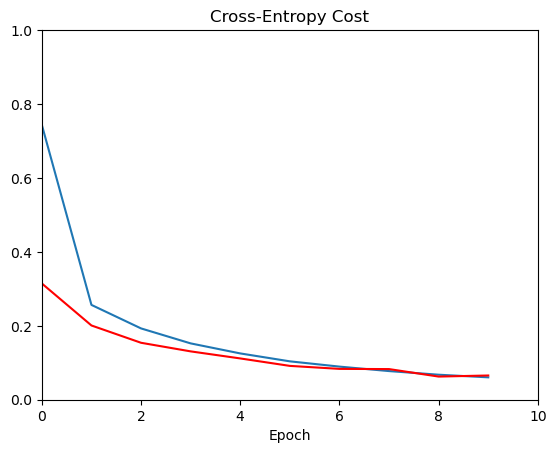

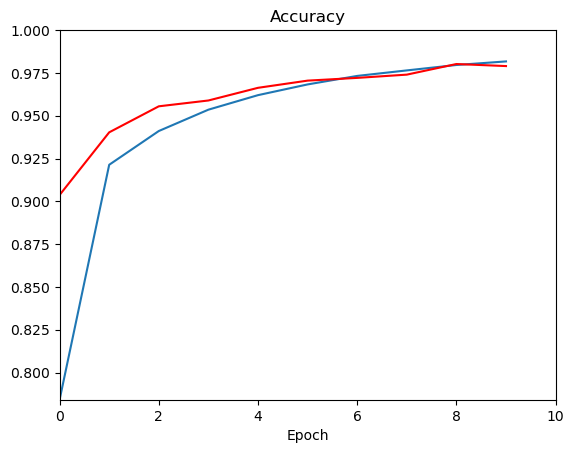

In [9]:
plot_training(nepochs, cost_hist, cost_hist_test, acc_hist, acc_hist_test)

#### Hyper-Parameter Tuning

Modify learning rate, batchsize, number of layers and units per layer and explore what changes these modification have on performance (train and test accuracy).

...

#### GPU

In [10]:
torch.cuda.is_available()

False

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = CNN2Layer2MLPLayer(nhidden=50, noutput=10).to(device)
cost_ce = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
size = len(training_loader.dataset)
nbatches = len(training_loader)

Xtest, Ytest = next(iter(test_loader))

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss = cost_ce(pred, Y)
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    cost /= nbatches
    acc /= size
    
    with torch.no_grad():
        pred = model(Xtest)
        cost_test = cost_ce(pred, Ytest).item()
        acc_test = (pred.argmax(dim=1) == Ytest).type(torch.float).mean().item()
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.788949, 0.763933, 0.384265, 0.877800
Epoch 1: 0.268485, 0.916217, 0.415892, 0.871300
Epoch 2: 0.205766, 0.936450, 0.188755, 0.941100
Epoch 3: 0.167633, 0.949350, 0.171370, 0.947200
Epoch 4: 0.142271, 0.956533, 0.120373, 0.963400
Epoch 5: 0.118653, 0.963250, 0.098414, 0.970600
Epoch 6: 0.099874, 0.968900, 0.092871, 0.971400
Epoch 7: 0.087373, 0.973383, 0.079062, 0.976000
Epoch 8: 0.076026, 0.976900, 0.071989, 0.978100
Epoch 9: 0.067260, 0.979050, 0.090433, 0.971100
